### Imports

In [70]:
import random
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from astropy.modeling import models, fitting
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error
from astropy.stats import akaike_info_criterion_lsq
from tabulate import tabulate
from scipy.signal import find_peaks


### Single signal visualization from csv

In [5]:
# Manually find number of points in a signal
file = 'mangaHI-7972-3701.csv'
timeSeries = pd.read_csv(file, names=['vHI', 'fHI', 'fBHI'])

time = timeSeries[22:-1].copy()
time[['vHI', 'fHI', 'fBHI']] = time['vHI'].str.split(expand=True)
time = time.reset_index(drop=True).astype(float)

signal = time['vHI'].values

num_points = len(signal)
print(f"Signal has {num_points} points.")


Signal has 948 points.


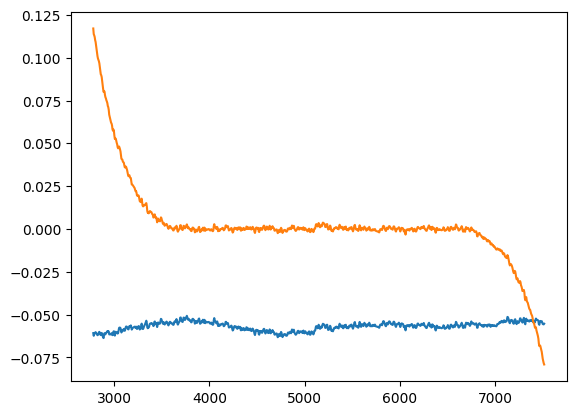

In [51]:
file = 'mangaHI-7972-3701.csv'

timeSeries = pd.read_csv(file, names = ('vHI','fHI', 'fBHI'))

time = timeSeries[22:-1].copy()
time[['vHI','fHI','fBHI']] = time['vHI'].str.split(expand=True)
time = time.reset_index(drop=True).astype(float)

plt.plot(time['vHI'], time['fBHI'])
plt.plot(time['vHI'], time['fHI'])

plt.show()

### Manually select a csv file, perform gaussian fitting and error estimation

C:\Users\petri\AppData\Local\Temp\ipykernel_18304\602277704.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  timeSeries = pd.read_csv(file, delim_whitespace=True, comment="#", names=["vHI", "fHI"])


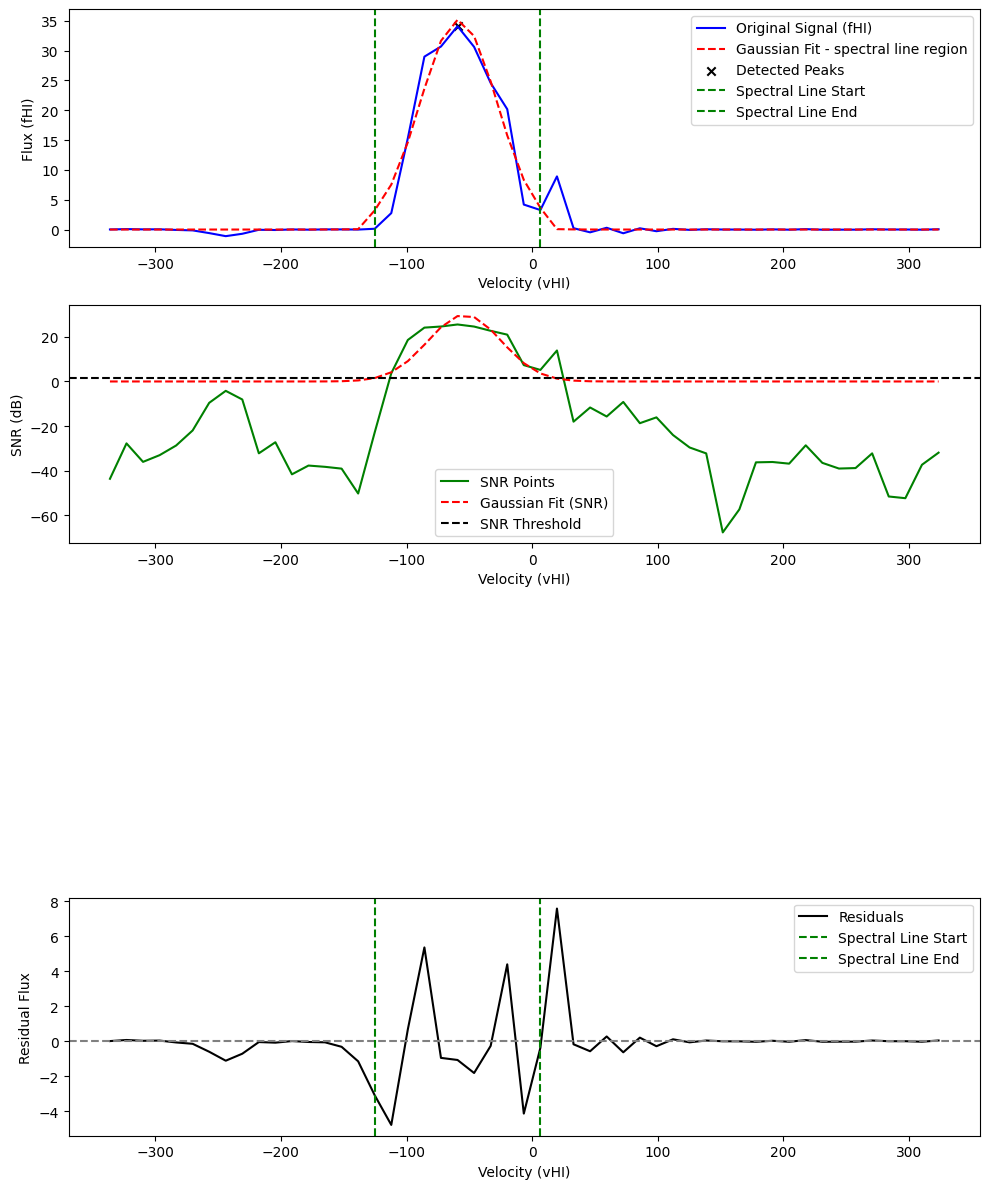

In [84]:
# Input file
file = "NGC 6822.txt"

# Determine file type
file_extension = os.path.splitext(file)[-1].lower()

# Load data
if file_extension == ".csv":
    timeSeries = pd.read_csv(file, names=["vHI", "fHI", "fBHI"])
    time = timeSeries[22:-1].copy()
    time[["vHI", "fHI", "fBHI"]] = time["vHI"].str.split(expand=True)
    time = time.reset_index(drop=True).astype(float)
    
    x = time["vHI"].values
    y = time["fHI"].values  # Used for Gaussian fitting
    y_original = time["fBHI"].values  # Original signal for plotting

elif file_extension == ".txt":
    timeSeries = pd.read_csv(file, delim_whitespace=True, comment="#", names=["vHI", "fHI"])
    x = timeSeries["vHI"].values
    y = timeSeries["fHI"].values
    y_original = None  # No fBHI in txt file data

# Clip signal by omitting the first and last 17% of the points
n_points = len(x)
clip_fraction = 0.17
start_index = int(n_points * clip_fraction)
end_index = int(n_points * (1 - clip_fraction)) - 1

x_trimmed = x[start_index:end_index+1]
y_trimmed = y[start_index:end_index+1]
if y_original is not None:
    y_original_trimmed = y_original[start_index:end_index+1]

# Find peaks in the signal
peak_indices, properties = find_peaks(y_trimmed, height=np.mean(y_trimmed) + 2 * np.std(y_trimmed), 
                                      prominence=np.std(y_trimmed) / 2, width=2)

# Fit a Gaussian model to each detected peak
if len(peak_indices) > 0:
    fitter = fitting.LevMarLSQFitter()
    g_init = None

    for peak_idx in peak_indices:
        peak_x = x_trimmed[peak_idx]
        peak_y = y_trimmed[peak_idx]
        stddev_guess = 5  # Initial guess

        # Create a Gaussian model for this peak
        g_model = models.Gaussian1D(amplitude=peak_y, mean=peak_x, stddev=stddev_guess)

        if g_init is None:
            g_init = g_model
        else:
            g_init += g_model  # Sum multiple Gaussians

    # Fit the combined Gaussian model
    g_fit = fitter(g_init, x_trimmed, y_trimmed)
    signal_fit = g_fit(x_trimmed)

else:
    print("No significant peaks found.")
    signal_fit = np.zeros_like(y_trimmed)

# Compute residuals (fHI - Gaussian fit)
residuals = y_trimmed - signal_fit

# Implement SNR logic
snr_threshold = 1.5  # Adjusted for Gaussian fit
snr_points = 20 * np.log10(np.abs(y_trimmed / np.std(residuals)))
SNR_g_init = models.Gaussian1D(amplitude=max(snr_points), mean=np.mean(x_trimmed), stddev=10)
SNR_g_fit = fitter(SNR_g_init, x_trimmed, snr_points)

# Identify spectral line region based on SNR
line_indices = np.where(SNR_g_fit(x_trimmed) > snr_threshold)[0]

# Suppress Fit Outside Spectral Line Region
mask = np.zeros_like(y_trimmed)
if len(line_indices) > 0:
    mask[line_indices] = 1
    signal_fit = signal_fit * mask + signal_fit * (1 - mask) * 0.05  # Reduce non-spectral regions

# Plot results
plt.figure(figsize=(10, 12))

# Plot 1: fHI signal and Gaussian fit
plt.subplot(4, 1, 1)
plt.plot(x_trimmed, y_trimmed, 'b-', label='Original Signal (fHI)')
plt.plot(x_trimmed, signal_fit, 'r--', label='Gaussian Fit - spectral line region')
plt.scatter(x_trimmed[peak_indices], y_trimmed[peak_indices], color='black', marker='x', label="Detected Peaks")
if len(line_indices) > 0:
    plt.axvline(x_trimmed[line_indices[0]], color='g', linestyle='--', label="Spectral Line Start")
    plt.axvline(x_trimmed[line_indices[-1]], color='g', linestyle='--', label="Spectral Line End")
plt.xlabel("Velocity (vHI)")
plt.ylabel("Flux (fHI)")
plt.legend()

# Plot 2: SNR points and Gaussian fit
plt.subplot(4, 1, 2)
plt.plot(x_trimmed, snr_points, 'g-', label='SNR Points')
plt.plot(x_trimmed, SNR_g_fit(x_trimmed), 'r--', label="Gaussian Fit (SNR)")
plt.axhline(y=snr_threshold, color='k', linestyle='--', label='SNR Threshold')
plt.xlabel("Velocity (vHI)")
plt.ylabel("SNR (dB)")
plt.legend()

# Plot 3: Original fBHI signal (Only for CSV input)
if y_original is not None:
    plt.subplot(4, 1, 3)
    plt.plot(x, y_original, 'm-', label='Original Signal (fBHI)')
    plt.xlabel("Velocity (vHI)")
    plt.ylabel("Flux (fBHI)")
    plt.legend()

# Plot 4: Residuals (fHI - Gaussian fit)
plt.subplot(4, 1, 4)
plt.plot(x_trimmed, residuals, '-k', label='Residuals')
plt.axhline(0, color='gray', linestyle='--')
if len(line_indices) > 0:
    plt.axvline(x_trimmed[line_indices[0]], color='g', linestyle='--', label="Spectral Line Start")
    plt.axvline(x_trimmed[line_indices[-1]], color='g', linestyle='--', label="Spectral Line End")
plt.xlabel("Velocity (vHI)")
plt.ylabel("Residual Flux")
plt.legend()

plt.tight_layout()
plt.show()

#### Metrics calculation

In [78]:
if len(line_indices) > 0:
    # Define regions:
    before_line = np.arange(0, line_indices[0])
    spectral_line = line_indices
    after_line = np.arange(line_indices[-1] + 1, len(x_trimmed))

    # --- MSE and RMSE Calculations ---
    fit_values = g_fit(x_trimmed)
    
    # Region 1: Before spectral line
    if len(before_line) > 0:
        mse_region1 = mean_squared_error(y_trimmed[before_line], fit_values[before_line])
        rmse_region1 = np.sqrt(mse_region1)
    else:
        mse_region1 = np.nan
        rmse_region1 = np.nan

    # Region 2: Spectral line region
    if len(spectral_line) > 0:
        mse_region2 = mean_squared_error(y_trimmed[spectral_line], fit_values[spectral_line])
        rmse_region2 = np.sqrt(mse_region2)
    else:
        mse_region2 = np.nan
        rmse_region2 = np.nan

    # Region 3: After spectral line
    if len(after_line) > 0:
        mse_region3 = mean_squared_error(y_trimmed[after_line], fit_values[after_line])
        rmse_region3 = np.sqrt(mse_region3)
    else:
        mse_region3 = np.nan
        rmse_region3 = np.nan

# Percentage differences
pct_diff_mse_1_2 = (abs(mse_region2 - mse_region1) / mse_region1) * 100 if mse_region1 and mse_region1 != 0 else np.nan
pct_diff_mse_1_3 = (abs(mse_region3 - mse_region1) / mse_region1) * 100 if mse_region1 and mse_region1 != 0 else np.nan
pct_diff_rmse_1_2 = (abs(rmse_region2 - rmse_region1) / rmse_region1) * 100 if rmse_region1 and rmse_region1 != 0 else np.nan
pct_diff_rmse_1_3 = (abs(rmse_region3 - rmse_region1) / rmse_region1) * 100 if rmse_region1 and rmse_region1 != 0 else np.nan

# --- Noise Statistics on the Residuals ---
mean_line = np.mean(residuals[spectral_line]) if len(spectral_line) > 0 else np.nan
std_line = np.std(residuals[spectral_line]) if len(spectral_line) > 0 else np.nan
mean_non_line = np.mean(residuals[before_line]) if len(before_line) > 0 else np.nan
std_non_line = np.std(residuals[before_line]) if len(before_line) > 0 else np.nan

std_diff_percentage = ((std_line - std_non_line) / std_non_line) * 100 if std_non_line > 0 else np.nan
mean_diff_percentage = ((mean_line - mean_non_line) / abs(mean_non_line)) * 100 if mean_non_line != 0 else np.nan

# --- SNR calculations ---
# 1. Spectral line region SNR using mean value of signal and noise
signal_power = np.mean(y_trimmed[spectral_line])  # Mean value of signal
noise_power = np.mean(residuals) # Mean value of residuals (noise)
snr_residuals = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.nan

# 2. Spectral line region SNR using average of SNR calculated at each point
avg_snr = np.mean(snr_points)

# --- Print Results ---
print("\n--- Spectral line region SNR Calculations ---")
print(f"SNR (Mean Signal value / Mean Noise value) : {snr_residuals:.2f} dB")
print(f"SNR (Average of SNR calculated at each point): {avg_snr:.2f} dB")

# Present metrics in formatted tables
try:
    table_noise = [
        ["Spectral Line Region (Residuals) Mean", f"{mean_line:.6f}"],
        ["Spectral Line Region (Residuals) Std Dev", f"{std_line:.6f}"],
        ["Non-Spectral Line Region (Residuals) Mean", f"{mean_non_line:.6f}"],
        ["Non-Spectral Line Region (Residuals) Std Dev", f"{std_non_line:.6f}"],
        ["% Diff in Mean (Residuals)", f"{mean_diff_percentage:.2f}%"],
        ["% Diff in Std Dev (Residuals)", f"{std_diff_percentage:.2f}%"],
    ]
    table_mse_rmse = [
        ["MSE (Region 1, Before)", f"{mse_region1:.8f}"],
        ["MSE (Region 2, Spectral)", f"{mse_region2:.8f}"],
        ["MSE (Region 3, After)", f"{mse_region3:.8f}"],
        ["RMSE (Region 1, Before)", f"{rmse_region1:.8f}"],
        ["RMSE (Region 2, Spectral)", f"{rmse_region2:.8f}"],
        ["RMSE (Region 3, After)", f"{rmse_region3:.8f}"],
        ["% Diff in MSE (R1 vs R2)", f"{pct_diff_mse_1_2:.2f}%"],
        ["% Diff in MSE (R1 vs R3)", f"{pct_diff_mse_1_3:.2f}%"],
        ["% Diff in RMSE (R1 vs R2)", f"{pct_diff_rmse_1_2:.2f}%"],
        ["% Diff in RMSE (R1 vs R3)", f"{pct_diff_rmse_1_3:.2f}%"],
    ]
    print("\n--- Noise Statistics (Residuals) ---")
    print(tabulate(table_noise, headers=["Metric", "Value"], tablefmt="pretty", showindex=False))
    print("\n--- MSE and RMSE Comparisons ---")
    print(tabulate(table_mse_rmse, headers=["Metric", "Value"], tablefmt="pretty", showindex=False))
except ImportError:
    print("--- Noise Statistics (Residuals) ---")
    print(f"Spectral Line Region -> Mean: {mean_line:.6f}, Std Dev: {std_line:.6f}")
    print(f"Non-Spectral Line Region -> Mean: {mean_non_line:.6f}, Std Dev: {std_non_line:.6f}")
    print(f"% Diff in Mean: {mean_diff_percentage:.2f}%")
    print(f"% Diff in Std Dev: {std_diff_percentage:.2f}%")
    print("------------------------------------")
    print("--- MSE and RMSE Comparisons ---")
    print(f"MSE (Region 1, Before): {mse_region1:.8f}")
    print(f"MSE (Region 2, Spectral): {mse_region2:.8f}")
    print(f"MSE (Region 3, After): {mse_region3:.8f}")
    print(f"RMSE (Region 1, Before): {rmse_region1:.8f}")
    print(f"RMSE (Region 2, Spectral): {rmse_region2:.8f}")
    print(f"RMSE (Region 3, After): {rmse_region3:.8f}")
    print(f"% Diff in MSE (R1 vs R2): {pct_diff_mse_1_2:.2f}%")
    print(f"% Diff in MSE (R1 vs R3): {pct_diff_mse_1_3:.2f}%")
    print(f"% Diff in RMSE (R1 vs R2): {pct_diff_rmse_1_2:.2f}%")
    print(f"% Diff in RMSE (R1 vs R3): {pct_diff_rmse_1_3:.2f}%")


--- Spectral line region SNR Calculations ---
SNR (Mean Signal value / Mean Noise value) : 19.85 dB
SNR (Average of SNR calculated at each point): -0.71 dB

--- Noise Statistics (Residuals) ---
+----------------------------------------------+-----------+
|                    Metric                    |   Value   |
+----------------------------------------------+-----------+
|    Spectral Line Region (Residuals) Mean     | -0.000053 |
|   Spectral Line Region (Residuals) Std Dev   | 0.001169  |
|  Non-Spectral Line Region (Residuals) Mean   | 0.000087  |
| Non-Spectral Line Region (Residuals) Std Dev | 0.001322  |
|          % Diff in Mean (Residuals)          | -161.00%  |
|        % Diff in Std Dev (Residuals)         |  -11.57%  |
+----------------------------------------------+-----------+

--- MSE and RMSE Comparisons ---
+---------------------------+------------+
|          Metric           |   Value    |
+---------------------------+------------+
|  MSE (Region 1, Before)   | 0.

#### SNR experimentation

0.0015715283356796115
7.687183596504418e-05
2.877642240131062


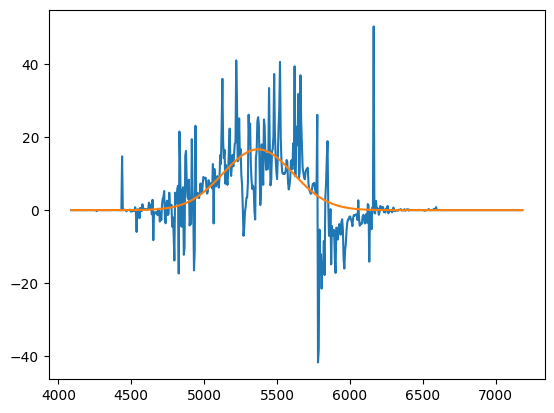

In [ ]:
#SNR experimentation
# 1. Spectral line region SNR using mean value of signal and noise
signal_power = np.mean(y_trimmed)  # Mean value of signal
noise_power = np.mean(residuals) # Mean value of residuals (noise)
snr_residuals = 20 * np.log10(signal_power / noise_power) if noise_power > 0 else np.nan
print(signal_power)
print(noise_power)

# 2. Spectral line region SNR using average of SNR calculated at each point
snr_points = 20 * np.log10(np.abs(y_trimmed / residuals))
avg_snr = np.mean(snr_points)
print(avg_snr)
g_init = models.Gaussian1D(amplitude=max(snr_points), mean=np.median(x_trimmed), stddev=10)
g_fit = fitter(g_init, x_trimmed, snr_points)

plt.plot(x_trimmed, snr_points)
plt.plot(x_trimmed, g_fit(x_trimmed))

### Fit 1 - 3 gaussian fits and compare metrics to find best fit


--- Gaussian Fit Comparisons ---

Gaussian 1:
  % Diff in MSE (R1 vs R2): 1.10%
  % Diff in RMSE (R1 vs R2): 0.55%
  % Diff in Mean (Residuals): 2794.70%
  % Diff in Std Dev (Residuals): -41.05%
  AIC Score: -8671.72

Gaussian 2:
  % Diff in MSE (R1 vs R2): 21.40%
  % Diff in RMSE (R1 vs R2): 11.35%
  % Diff in Mean (Residuals): -52.63%
  % Diff in Std Dev (Residuals): -11.29%
  AIC Score: -8664.47

Gaussian 3:
  % Diff in MSE (R1 vs R2): 54.97%
  % Diff in RMSE (R1 vs R2): 32.90%
  % Diff in Mean (Residuals): -627.08%
  % Diff in Std Dev (Residuals): -36.36%
  AIC Score: -8682.62

Best fit: 3 Gaussian(s) (Lowest AIC = -8682.62)


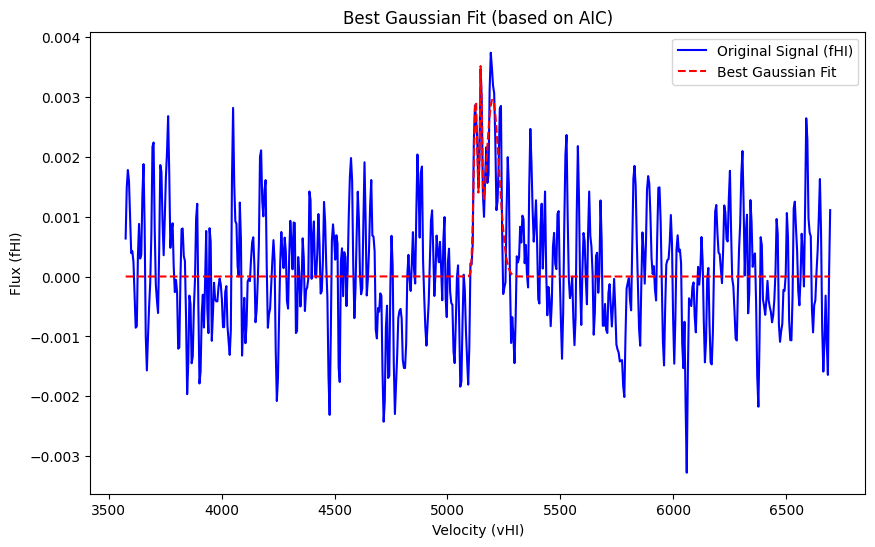

In [18]:
# Load data
file = 'mangaHI-7972-3701.csv'
timeSeries = pd.read_csv(file, names=['vHI', 'fHI', 'fBHI'])

time = timeSeries[22:-1].copy()
time[['vHI', 'fHI', 'fBHI']] = time['vHI'].str.split(expand=True)
time = time.reset_index(drop=True).astype(float)

x = time['vHI'].values
y = time['fHI'].values       # Used for Gaussian fitting (original fHI)
y_original = time['fBHI'].values  # Original signal from fBHI (for plotting)

# Clip signal by omitting the first and last 17% of the points
n_points = len(x)
clip_fraction = 0.17
start_index = int(n_points * clip_fraction)
end_index = int(n_points * (1 - clip_fraction)) - 1

x_trimmed = x[start_index:end_index+1]
y_trimmed = y[start_index:end_index+1]
y_original_trimmed = y_original[start_index:end_index+1]

# Function to fit Gaussian models
def fit_gaussians(num_gaussians):
    fitter = fitting.LevMarLSQFitter()
    
    # Initialize the first Gaussian
    g_init = models.Gaussian1D(amplitude=max(y_trimmed), mean=np.mean(x_trimmed), stddev=10)
    
    # Add additional Gaussians if necessary
    for i in range(1, num_gaussians):
        g_init += models.Gaussian1D(amplitude=max(y_trimmed) / (i + 1), mean=np.mean(x_trimmed) + i * 15, stddev=10)
    
    g_fit = fitter(g_init, x_trimmed, y_trimmed)
    return g_fit

# Fit 1, 2, and 3 gaussian fits
fits = {n: fit_gaussians(n) for n in [1, 2, 3]}

# Compute fit metrics
def compute_metrics(g_fit):
    residuals = y_trimmed - g_fit(x_trimmed)
    snr_points = 20 * np.log10(np.abs(y_trimmed / residuals))

    # Define the spectral line region
    SNR_g_init = models.Gaussian1D(amplitude=max(snr_points), mean=np.mean(x_trimmed), stddev=10)
    SNR_g_fit = fitting.LevMarLSQFitter()(SNR_g_init, x_trimmed, snr_points)
    line_indices = np.where(SNR_g_fit(x_trimmed) > 5)[0]

    if len(line_indices) > 0:
        before_line = np.arange(0, line_indices[0])
        spectral_line = line_indices

        mse_region1 = mean_squared_error(y_trimmed[before_line], g_fit(x_trimmed)[before_line]) if len(before_line) > 0 else np.nan
        mse_region2 = mean_squared_error(y_trimmed[spectral_line], g_fit(x_trimmed)[spectral_line]) if len(spectral_line) > 0 else np.nan

        rmse_region1 = np.sqrt(mse_region1) if not np.isnan(mse_region1) else np.nan
        rmse_region2 = np.sqrt(mse_region2) if not np.isnan(mse_region2) else np.nan

        pct_diff_mse = (abs(mse_region2 - mse_region1) / mse_region1) * 100 if mse_region1 and mse_region1 != 0 else np.nan
        pct_diff_rmse = (abs(rmse_region2 - rmse_region1) / rmse_region1) * 100 if rmse_region1 and rmse_region1 != 0 else np.nan

        mean_line = np.mean(residuals[spectral_line]) if len(spectral_line) > 0 else np.nan
        std_line = np.std(residuals[spectral_line]) if len(spectral_line) > 0 else np.nan
        mean_non_line = np.mean(residuals[before_line]) if len(before_line) > 0 else np.nan
        std_non_line = np.std(residuals[before_line]) if len(before_line) > 0 else np.nan

        mean_diff_percentage = ((mean_line - mean_non_line) / abs(mean_non_line)) * 100 if mean_non_line != 0 else np.nan
        std_diff_percentage = ((std_line - std_non_line) / std_non_line) * 100 if std_non_line > 0 else np.nan

        return {
            "g_fit": g_fit,
            "residuals": residuals,
            "mse": pct_diff_mse,
            "rmse": pct_diff_rmse,
            "mean_diff": mean_diff_percentage,
            "std_diff": std_diff_percentage
        }
    return None

# Compute AIC
def compute_aic(g_fit):
    residuals = y_trimmed - g_fit(x_trimmed)
    ssr = np.sum(residuals**2)  # Sum of squared residuals
    n_params = len(g_fit.parameters)  # Number of parameters in the model
    n_samples = len(y_trimmed)  # Number of data points

    return akaike_info_criterion_lsq(ssr, n_params, n_samples)

# Compute metrics and AIC values for all fits
metrics = {n: compute_metrics(fits[n]) for n in fits if compute_metrics(fits[n]) is not None}
aic_values = {n: compute_aic(fits[n]) for n in fits if fits[n] is not None}

if metrics and aic_values:
    # Select the best fit using the lowest AIC value
    best_fit_n = min(aic_values.items(), key=lambda x: x[1])[0]
    best_fit = fits[best_fit_n]

    # Print comparison results
    print("\n--- Gaussian Fit Comparisons ---")
    for n, result in metrics.items():
        print(f"\nGaussian {n}:")
        print(f"  % Diff in MSE (R1 vs R2): {result['mse']:.2f}%")
        print(f"  % Diff in RMSE (R1 vs R2): {result['rmse']:.2f}%")
        print(f"  % Diff in Mean (Residuals): {result['mean_diff']:.2f}%")
        print(f"  % Diff in Std Dev (Residuals): {result['std_diff']:.2f}%")
        print(f"  AIC Score: {aic_values[n]:.2f}")

    print(f"\nBest fit: {best_fit_n} Gaussian(s) (Lowest AIC = {aic_values[best_fit_n]:.2f})")

    # Plot the best fit
    plt.figure(figsize=(10, 6))
    plt.plot(x_trimmed, y_trimmed, 'b-', label='Original Signal (fHI)')
    plt.plot(x_trimmed, best_fit(x_trimmed), 'r--', label='Best Gaussian Fit')
    plt.xlabel("Velocity (vHI)")
    plt.ylabel("Flux (fHI)")
    plt.legend()
    plt.title("Best Gaussian Fit (based on AIC)")
    plt.show()
else:
    print("No spectral line regions found suitable for fitting.")

#### Calculate metrics for detected spectral line (best fit)

--- HI Spectral Line Parameters (on signal) ---
Peak Intensity (I_peak): 0.004 mJy
FWZI (Full Width at Zero Intensity): 109.977 km/s
W20 (Width at 20% of Peak): 134.978 km/s
W50 (Width at 50% of Peak): 109.977 km/s
Systemic Velocity (V_sys): 5171.702 km/s
Integrated Flux (Sint): 0.308 Jy km/s


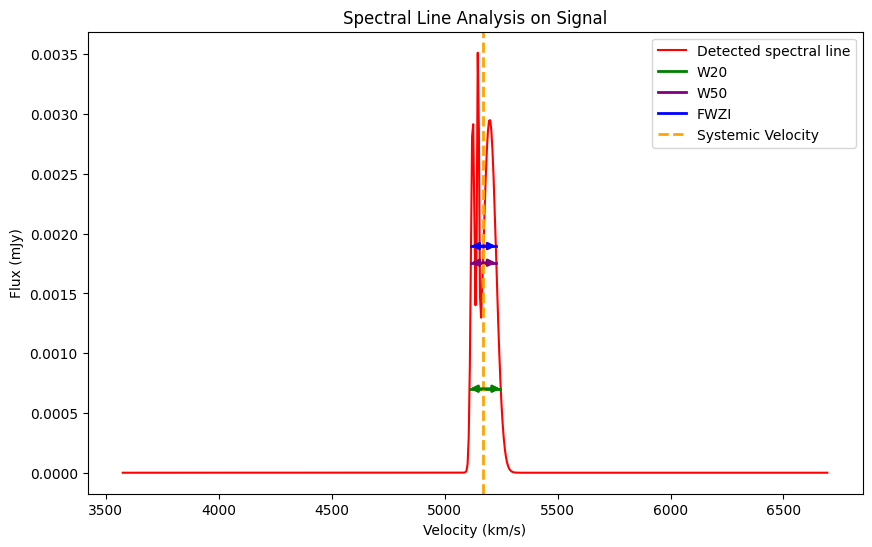

In [16]:
signal = best_fit(x_trimmed)

# Peak Intensity (I_peak)
I_peak = np.max(signal)

# Full Width at Zero Intensity (FWZI)
residuals = y_trimmed - signal
sigma_noise = np.std(residuals)
detection_threshold = 2 * sigma_noise

fwzi_mask = np.where(signal >= detection_threshold)[0]
FWZI = x_trimmed[fwzi_mask[-1]] - x_trimmed[fwzi_mask[0]]
fwzi_range = [x_trimmed[fwzi_mask[0]], x_trimmed[fwzi_mask[-1]]]

# W20 (Width at 20% of Peak)
v20_indices = np.where(signal >= 0.2 * I_peak)[0]
W20 = x_trimmed[v20_indices[-1]] - x_trimmed[v20_indices[0]]
w20_range = [x_trimmed[v20_indices[0]], x_trimmed[v20_indices[-1]]]

# W50 (Width at 50% of Peak)
v50_indices = np.where(signal >= 0.5 * I_peak)[0]
W50 = x_trimmed[v50_indices[-1]] - x_trimmed[v50_indices[0]]
w50_range = [x_trimmed[v50_indices[0]], x_trimmed[v50_indices[-1]]]

# Systemic Velocity (V_sys)
V_sys = (x_trimmed[v50_indices[0]] + x_trimmed[v50_indices[-1]]) / 2

# Integrated Flux (Sint)
velocity_channel_width = np.abs(np.mean(np.diff(x_trimmed)))
Sint = np.sum(signal) * velocity_channel_width # Approximate integral

# Print results
print("--- HI Spectral Line Parameters (on signal) ---")
print(f"Peak Intensity (I_peak): {I_peak:.3f} mJy")
print(f"FWZI (Full Width at Zero Intensity): {FWZI:.3f} km/s")
print(f"W20 (Width at 20% of Peak): {W20:.3f} km/s")
print(f"W50 (Width at 50% of Peak): {W50:.3f} km/s")
print(f"Systemic Velocity (V_sys): {V_sys:.3f} km/s")
print(f"Integrated Flux (Sint): {Sint:.3f} Jy km/s")

# Plot signal
plt.figure(figsize=(10, 6))
plt.plot(x_trimmed, signal, 'r-', label='Detected spectral line')

# Horizontal lines
plt.plot(w20_range, [0.2 * I_peak] * 2, 'g-', lw=2, label="W20")
plt.plot(w50_range, [0.5 * I_peak] * 2, 'purple', lw=2, label="W50")
plt.plot(fwzi_range, [detection_threshold] * 2, 'blue', lw=2, label="FWZI")

plt.annotate("", xy=(w20_range[1], 0.2 * I_peak), xytext=(w20_range[0], 0.2 * I_peak),
             arrowprops=dict(arrowstyle="<|-|>", color="g", lw=2, shrinkA=0,shrinkB=0))
plt.annotate("", xy=(w50_range[1], 0.5 * I_peak), xytext=(w50_range[0], 0.5 * I_peak),
             arrowprops=dict(arrowstyle="<|-|>", color="purple", lw=2, shrinkA=0,shrinkB=0))
plt.annotate("", xy=(fwzi_range[1], detection_threshold), xytext=(fwzi_range[0], detection_threshold),
             arrowprops=dict(arrowstyle="<|-|>", color="blue", lw=2, shrinkA=0,shrinkB=0))

# Systemic velocity line
plt.axvline(V_sys, color='orange', linestyle='--', label="Systemic Velocity", lw=2)

plt.xlabel("Velocity (km/s)")
plt.ylabel("Flux (mJy)")
plt.legend()
plt.title("Spectral Line Analysis on Signal")
plt.show()

## Database access

### Connect to database and fetch a single signal

Selected src_file: mangaHI-8978-1901.csv
Fetched 1024 data points.


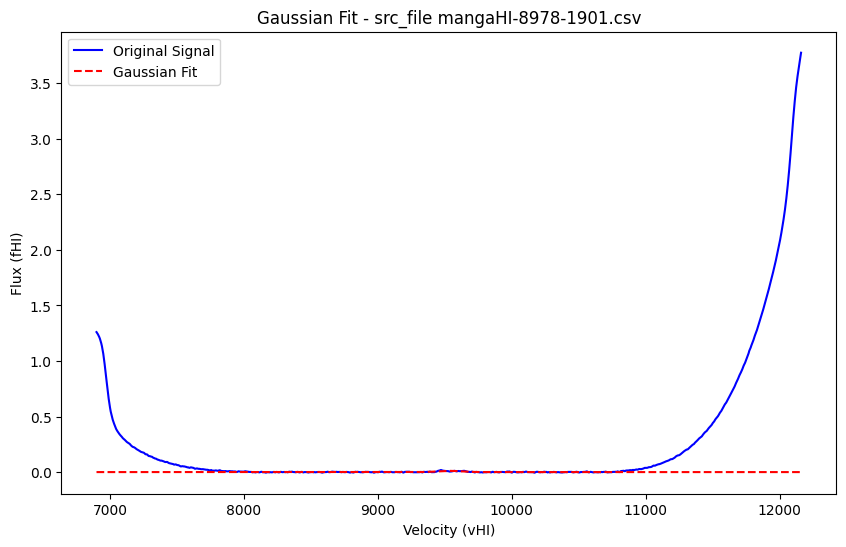

In [19]:
# Database connection details
db_config = {
    "host": "195.201.104.116",
    "user": "eta14802_astrobeam",
    "password": "PGdAR{F[1C#~",
    "database": "eta14802_astrobeam"
}

# Connect to the database
try:
    conn = mysql.connector.connect(**db_config)
    cursor = conn.cursor()

    # Find a src_file that has multiple points
    query = "SELECT src_file, COUNT(*) FROM gbt_data GROUP BY src_file ORDER BY COUNT(*) DESC LIMIT 1;"
    cursor.execute(query)
    src_file = cursor.fetchone()[0]
    print(f"Selected src_file: {src_file}")

    # Fetch all vHI and fHI values for that src_file
    query = f"SELECT vHI, fHI FROM gbt_data WHERE src_file = '{src_file}' ORDER BY vHI;"
    cursor.execute(query)
    data = pd.DataFrame(cursor.fetchall(), columns=["vHI", "fHI"])

    if data.empty:
        print("No data found for this src_file.")
    else:
        print(f"Fetched {len(data)} data points.")

    # Remove NaNs
    data = data.dropna()

    # Extract velocity and flux
    x = data["vHI"].values
    y = data["fHI"].values

    if len(x) < 3:
        print("Insufficient points for Gaussian fitting.")
    else:
        # Fit a Gaussian
        fitter = fitting.LevMarLSQFitter()
        g_init = models.Gaussian1D(amplitude=np.max(y), mean=np.median(x), stddev=10)
        g_fit = fitter(g_init, x, y)

        # Plot original signal and Gaussian fit
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, 'b-', label='Original Signal')
        plt.plot(x, g_fit(x), 'r--', label='Gaussian Fit')
        plt.xlabel("Velocity (vHI)")
        plt.ylabel("Flux (fHI)")
        plt.legend()
        plt.title(f"Gaussian Fit - src_file {src_file}")
        plt.show()

except mysql.connector.Error as err:
    print("Error:", err)

finally:
    cursor.close()
    conn.close()

### Fetch 20 random signals from the database and perform gaussian fitting and error estimation

Selected src_file: mangaHI-8978-1901.csv
Selected 20 random signals.
Results for signal mangaHI-8711-1901.csv:
  Spectral Line Region -> Mean: nan, Std Dev: nan
  Non-Spectral Line Region -> Mean: -0.000006, Std Dev: 0.001252
  Percentage Difference in Mean: nan%
  Percentage Difference in Std Dev: nan%
--------------------------------------------------


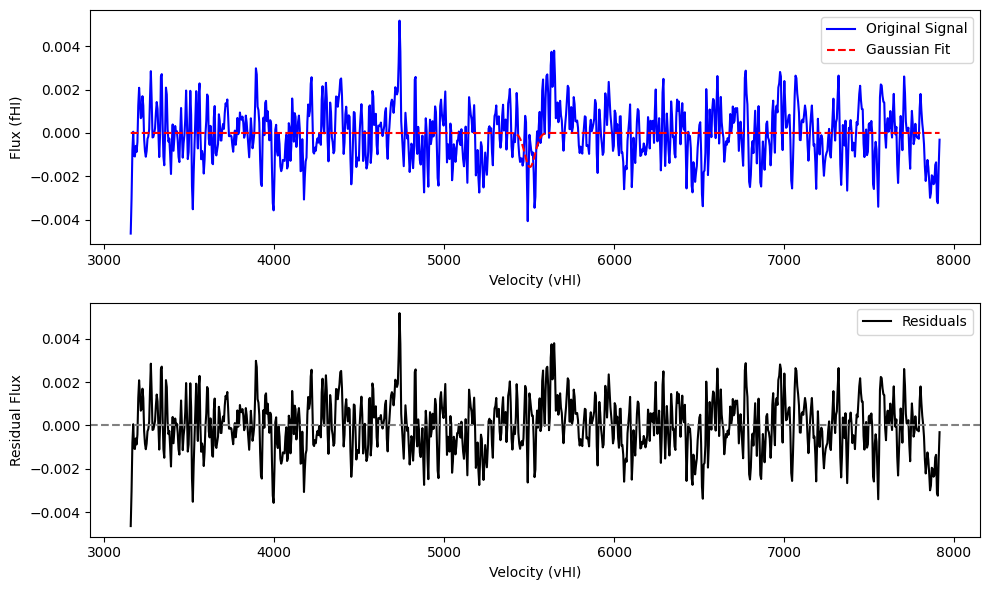

Data from signal mangaHI-8312-3704.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8312-3704.csv:
  Spectral Line Region -> Mean: nan, Std Dev: nan
  Non-Spectral Line Region -> Mean: 0.004719, Std Dev: 0.022766
  Percentage Difference in Mean: nan%
  Percentage Difference in Std Dev: nan%
--------------------------------------------------


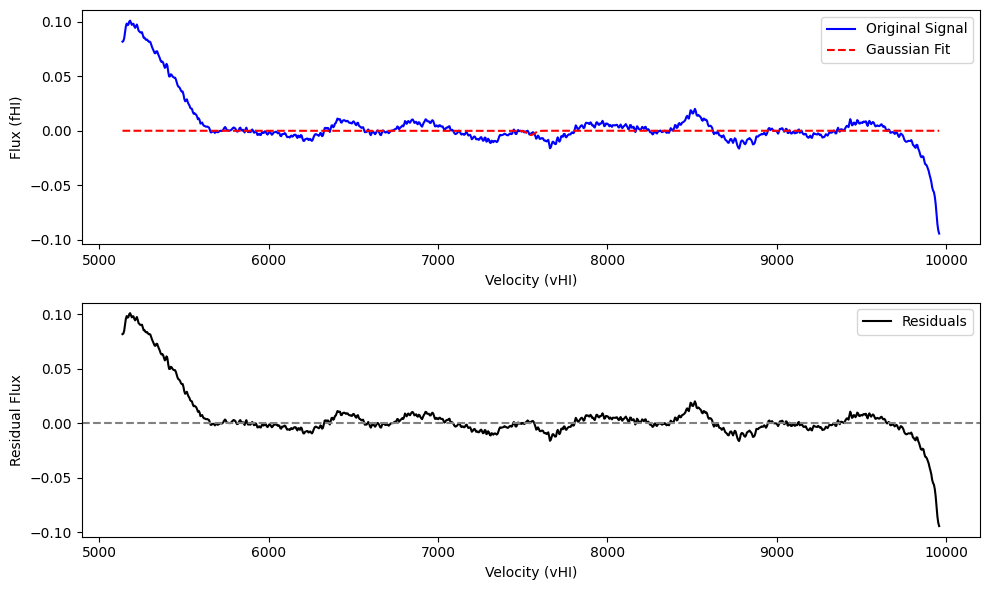

Data from signal mangaHI-9035-9101.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-9035-9101.csv:
  Spectral Line Region -> Mean: 0.000457, Std Dev: 0.001788
  Non-Spectral Line Region -> Mean: -0.000947, Std Dev: 0.002259
  Percentage Difference in Mean: 148.26%
  Percentage Difference in Std Dev: -20.85%
--------------------------------------------------


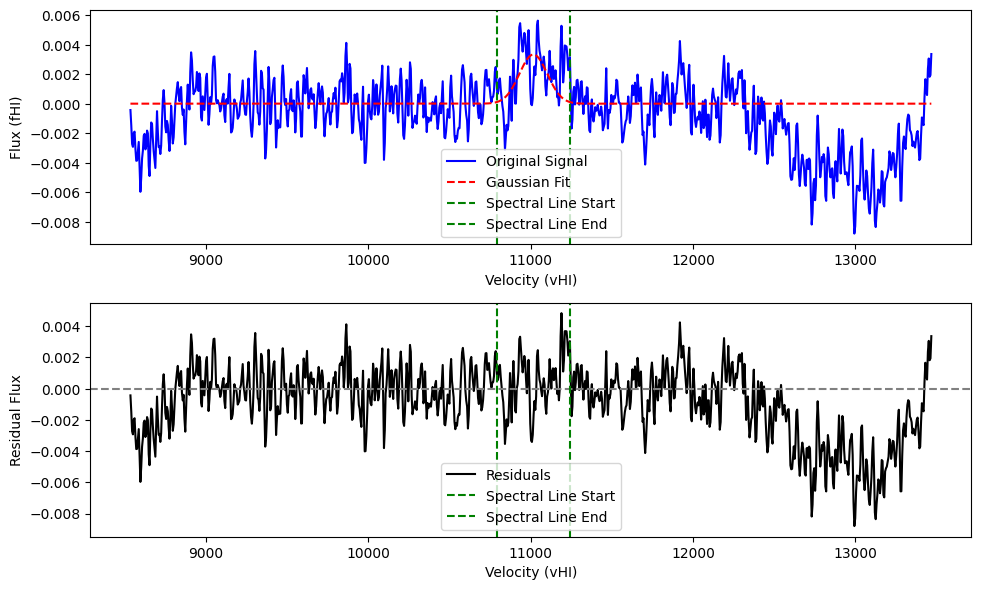

Data from signal mangaHI-8086-6103.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8086-6103.csv:
  Spectral Line Region -> Mean: nan, Std Dev: nan
  Non-Spectral Line Region -> Mean: 0.000838, Std Dev: 0.004224
  Percentage Difference in Mean: nan%
  Percentage Difference in Std Dev: nan%
--------------------------------------------------


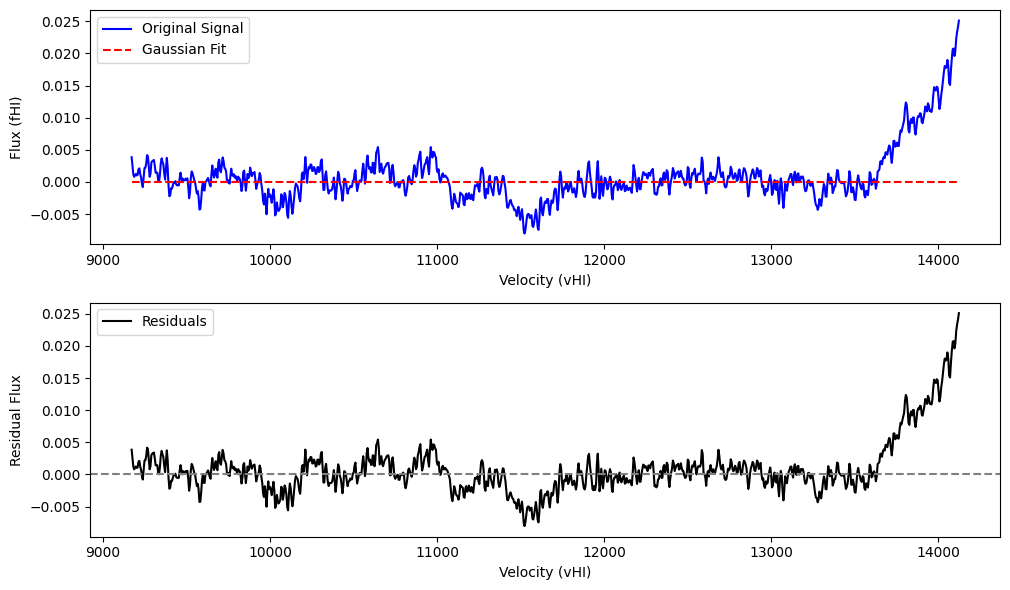

Data from signal mangaHI-8554-12705.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8554-12705.csv:
  Spectral Line Region -> Mean: nan, Std Dev: nan
  Non-Spectral Line Region -> Mean: -0.003570, Std Dev: 0.009312
  Percentage Difference in Mean: nan%
  Percentage Difference in Std Dev: nan%
--------------------------------------------------


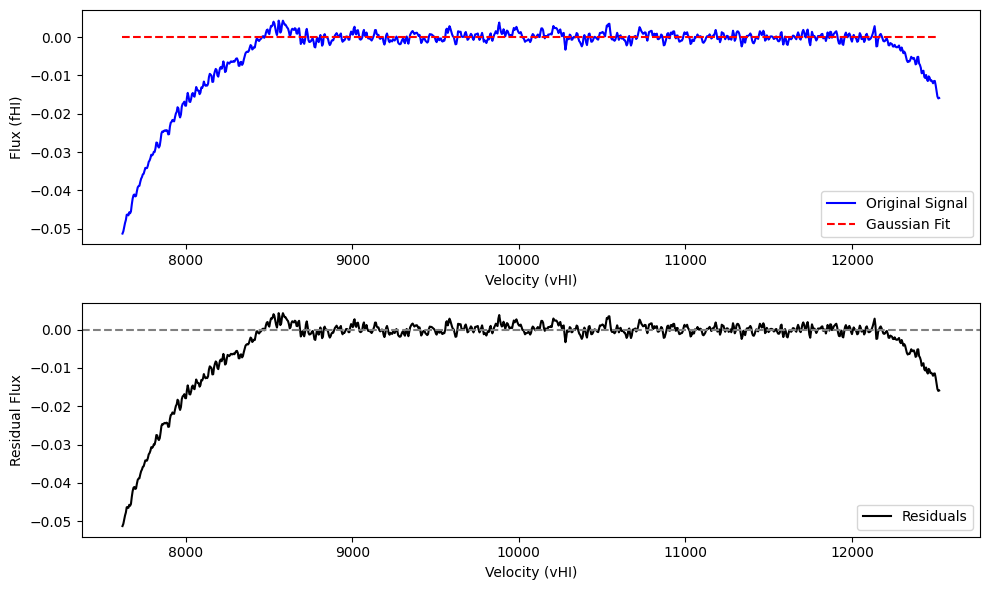

Data from signal mangaHI-10493-12705.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-10493-12705.csv:
  Spectral Line Region -> Mean: 0.002735, Std Dev: 0.002654
  Non-Spectral Line Region -> Mean: 0.000692, Std Dev: 0.003880
  Percentage Difference in Mean: 295.40%
  Percentage Difference in Std Dev: -31.59%
--------------------------------------------------


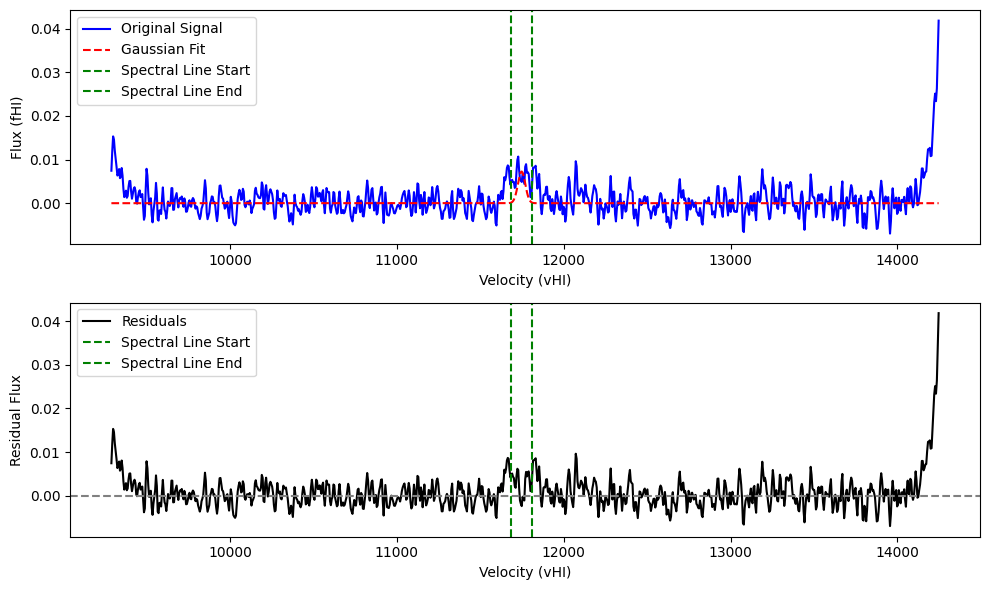

Data from signal mangaHI-8716-12702.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8716-12702.csv:
  Spectral Line Region -> Mean: -0.000076, Std Dev: 0.000621
  Non-Spectral Line Region -> Mean: 0.000923, Std Dev: 0.016407
  Percentage Difference in Mean: -108.27%
  Percentage Difference in Std Dev: -96.21%
--------------------------------------------------


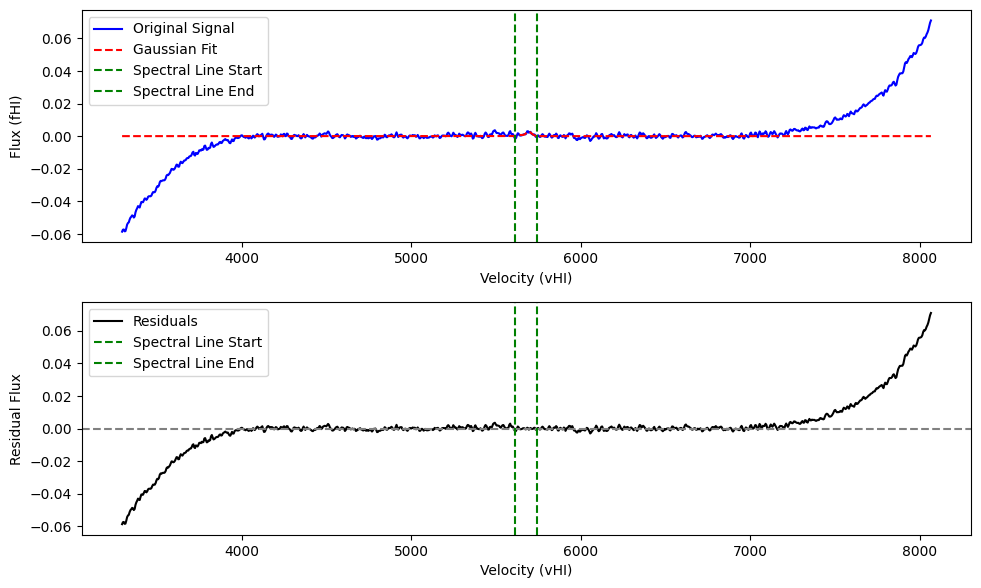

Data from signal mangaHI-8595-1902.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8595-1902.csv:
  Spectral Line Region -> Mean: 0.000071, Std Dev: 0.000102
  Non-Spectral Line Region -> Mean: -0.000022, Std Dev: 0.001350
  Percentage Difference in Mean: 427.23%
  Percentage Difference in Std Dev: -92.42%
--------------------------------------------------


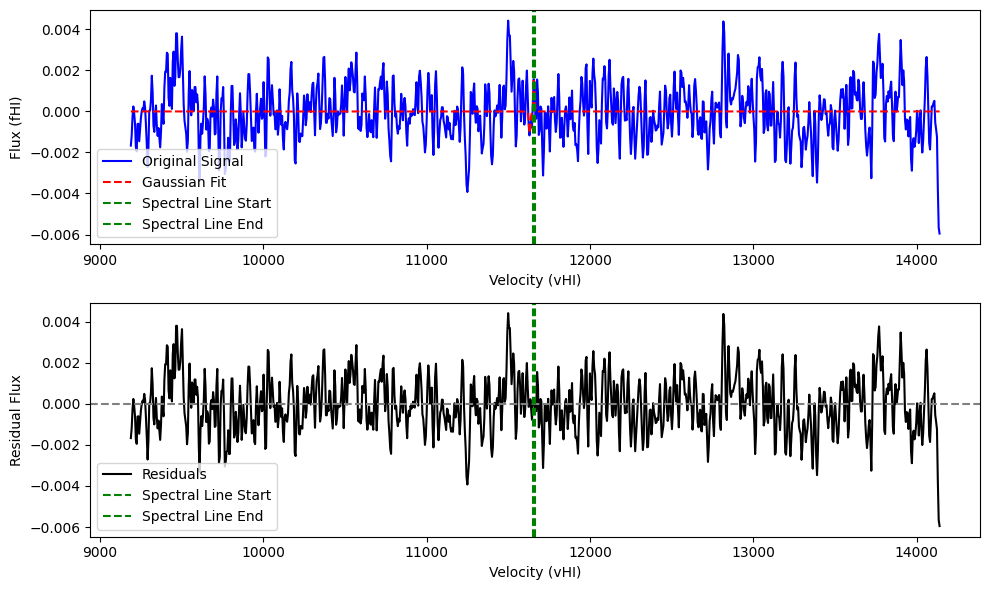

Data from signal mangaHI-7957-9101.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-7957-9101.csv:
  Spectral Line Region -> Mean: -0.000099, Std Dev: 0.001097
  Non-Spectral Line Region -> Mean: 0.003744, Std Dev: 0.009577
  Percentage Difference in Mean: -102.63%
  Percentage Difference in Std Dev: -88.55%
--------------------------------------------------


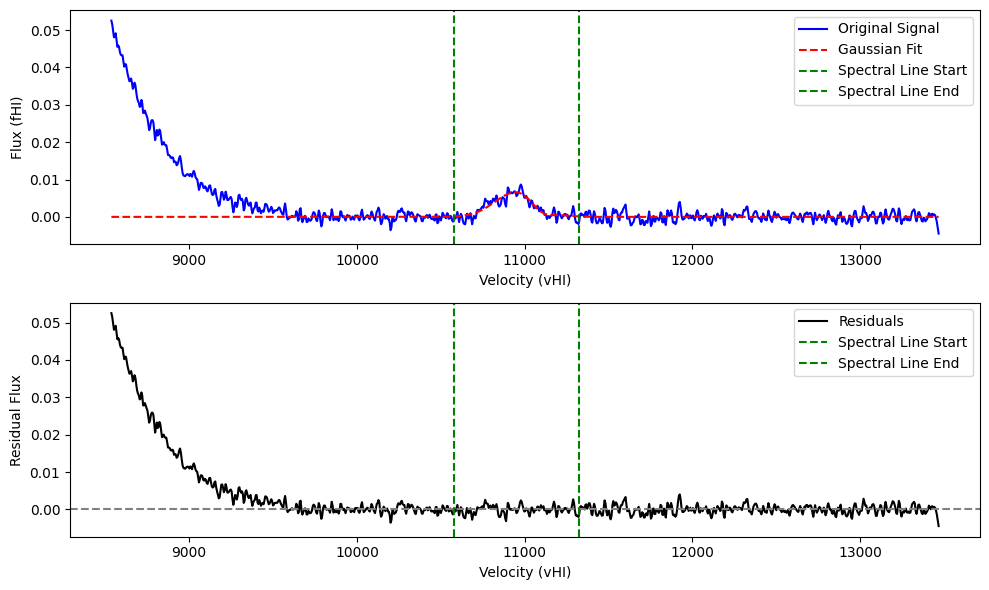

Data from signal mangaHI-7991-6102.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-7991-6102.csv:
  Spectral Line Region -> Mean: nan, Std Dev: nan
  Non-Spectral Line Region -> Mean: 0.000037, Std Dev: 0.003033
  Percentage Difference in Mean: nan%
  Percentage Difference in Std Dev: nan%
--------------------------------------------------


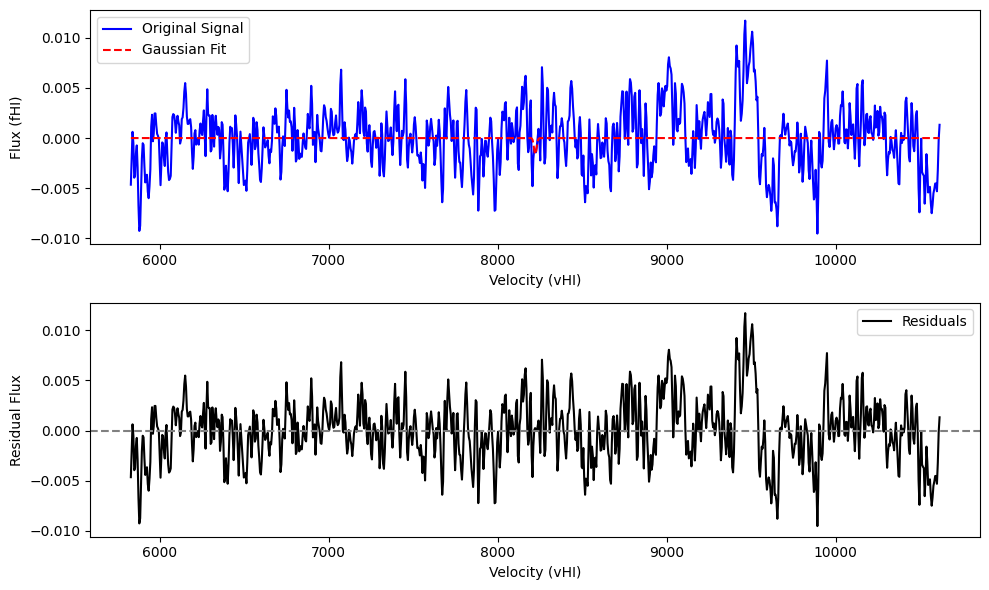

Data from signal mangaHI-11024-6102.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-11024-6102.csv:
  Spectral Line Region -> Mean: 0.000026, Std Dev: 0.000951
  Non-Spectral Line Region -> Mean: 0.000260, Std Dev: 0.001994
  Percentage Difference in Mean: -90.03%
  Percentage Difference in Std Dev: -52.30%
--------------------------------------------------


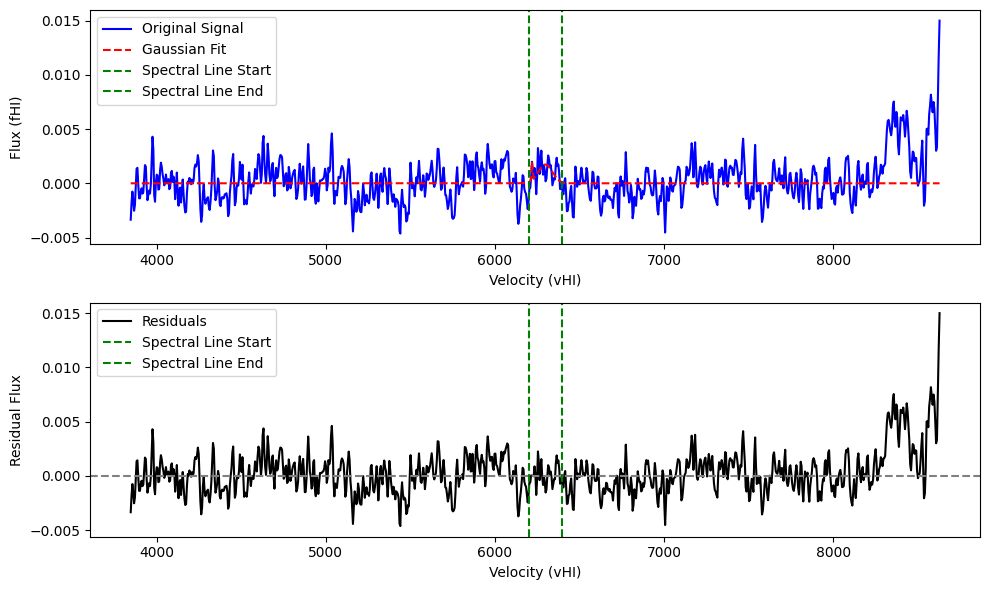

Data from signal mangaHI-8324-6102.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8324-6102.csv:
  Spectral Line Region -> Mean: 0.000050, Std Dev: 0.000960
  Non-Spectral Line Region -> Mean: -0.000145, Std Dev: 0.001737
  Percentage Difference in Mean: 134.69%
  Percentage Difference in Std Dev: -44.76%
--------------------------------------------------


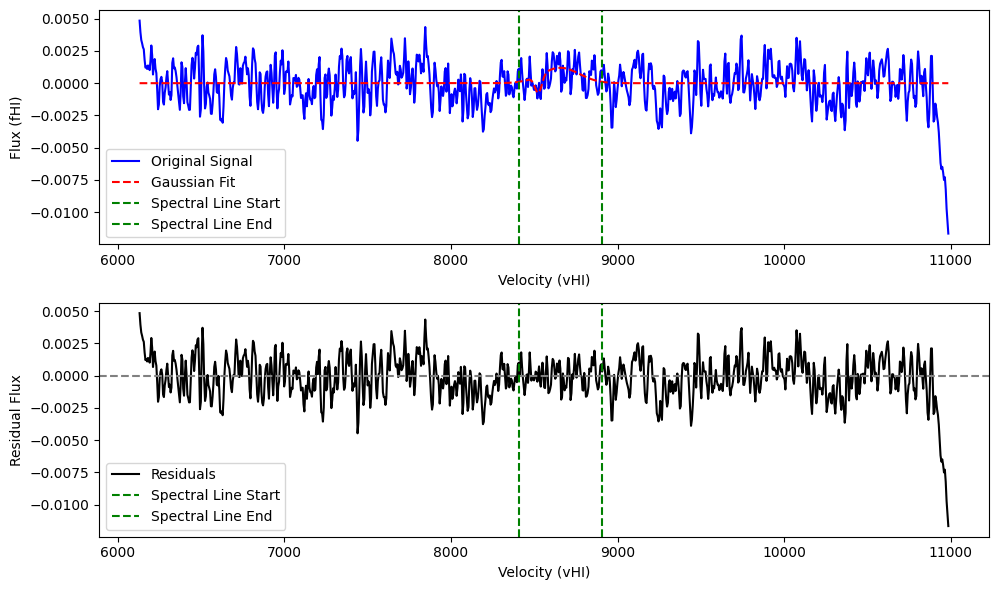

Data from signal mangaHI-11024-12704.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-11024-12704.csv:
  Spectral Line Region -> Mean: -0.000100, Std Dev: 0.001156
  Non-Spectral Line Region -> Mean: 0.000078, Std Dev: 0.001207
  Percentage Difference in Mean: -227.19%
  Percentage Difference in Std Dev: -4.26%
--------------------------------------------------


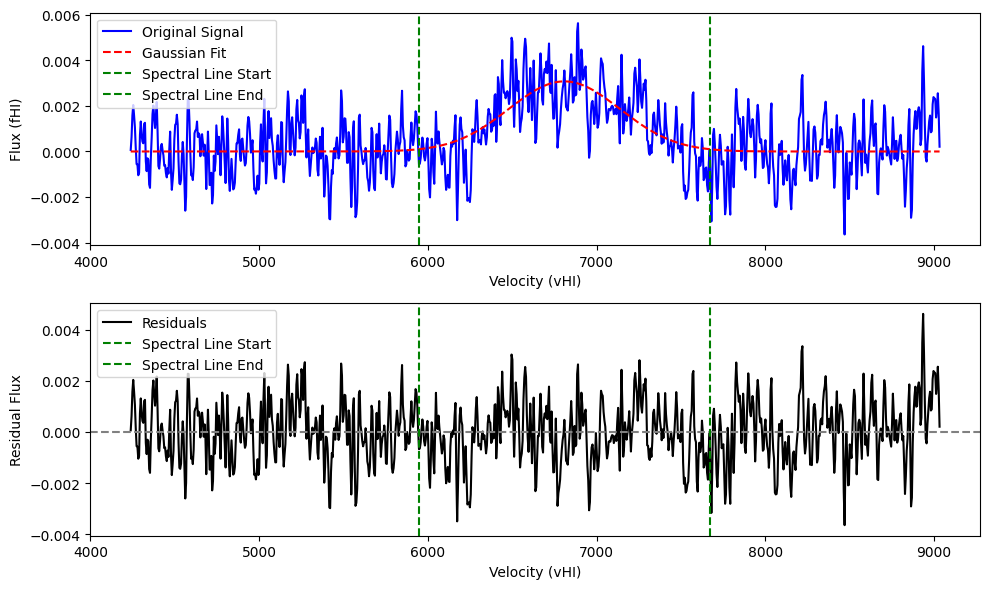

Data from signal mangaHI-8551-9101.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8551-9101.csv:
  Spectral Line Region -> Mean: 0.000080, Std Dev: 0.001548
  Non-Spectral Line Region -> Mean: -0.000139, Std Dev: 0.001479
  Percentage Difference in Mean: 157.76%
  Percentage Difference in Std Dev: 4.68%
--------------------------------------------------


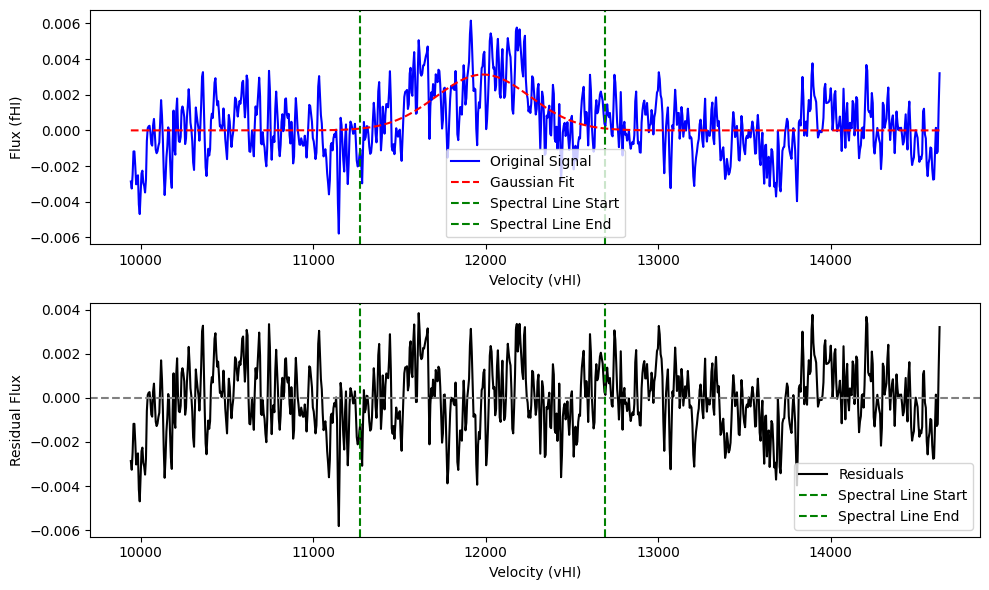

Data from signal mangaHI-8253-12701.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8253-12701.csv:
  Spectral Line Region -> Mean: -0.000116, Std Dev: 0.002088
  Non-Spectral Line Region -> Mean: -0.000246, Std Dev: 0.002401
  Percentage Difference in Mean: 52.75%
  Percentage Difference in Std Dev: -13.03%
--------------------------------------------------


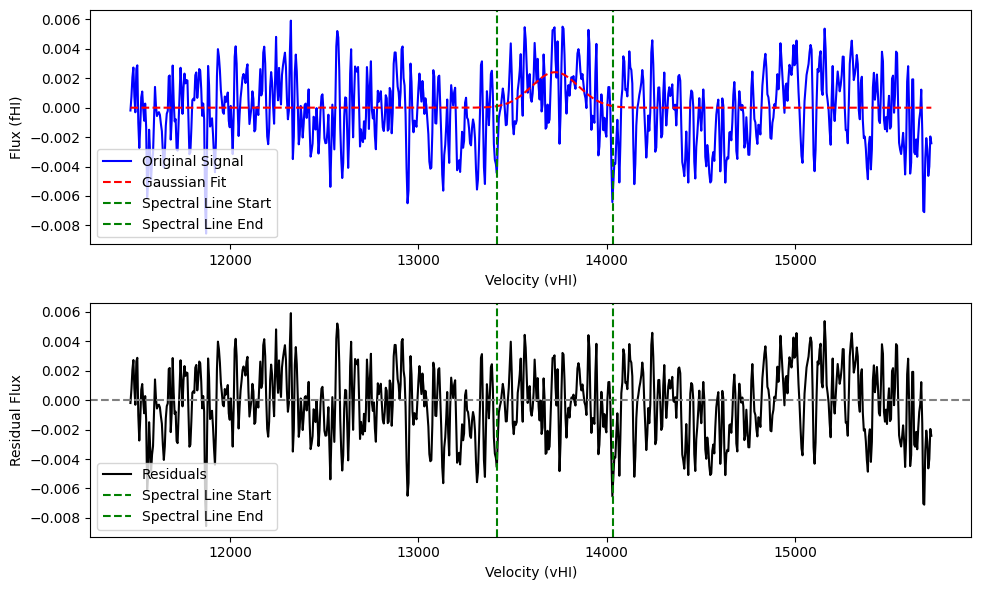

Data from signal mangaHI-8593-3703.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8593-3703.csv:
  Spectral Line Region -> Mean: -0.000092, Std Dev: 0.001205
  Non-Spectral Line Region -> Mean: 0.000178, Std Dev: 0.003524
  Percentage Difference in Mean: -151.74%
  Percentage Difference in Std Dev: -65.81%
--------------------------------------------------


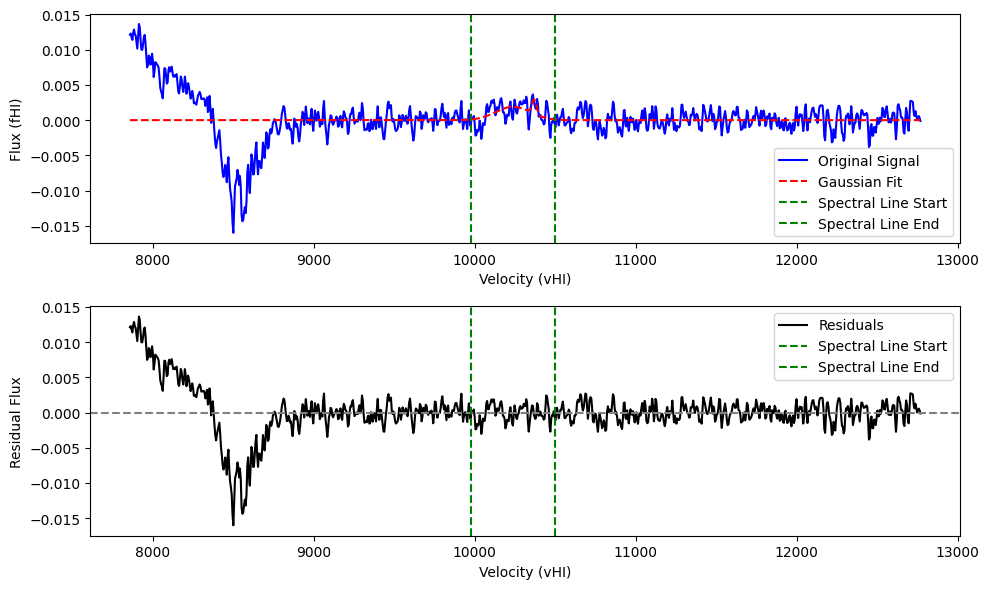

Data from signal mangaHI-8625-6102.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8625-6102.csv:
  Spectral Line Region -> Mean: -0.000175, Std Dev: 0.001386
  Non-Spectral Line Region -> Mean: -0.076617, Std Dev: 0.142906
  Percentage Difference in Mean: 99.77%
  Percentage Difference in Std Dev: -99.03%
--------------------------------------------------


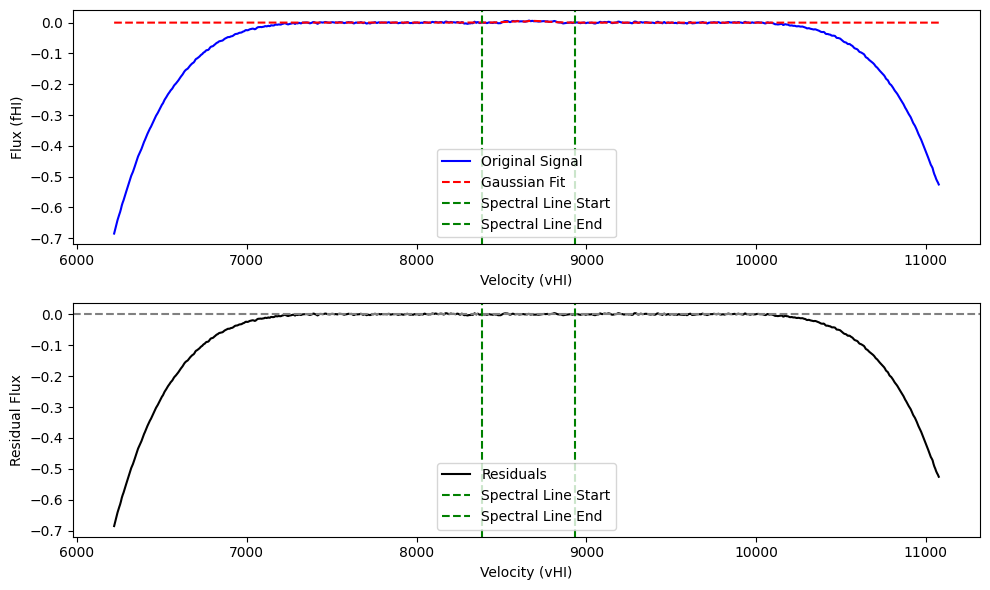

Data from signal mangaHI-8318-12703.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8318-12703.csv:
  Spectral Line Region -> Mean: 0.000156, Std Dev: 0.001758
  Non-Spectral Line Region -> Mean: -0.007484, Std Dev: 0.017346
  Percentage Difference in Mean: 102.08%
  Percentage Difference in Std Dev: -89.86%
--------------------------------------------------


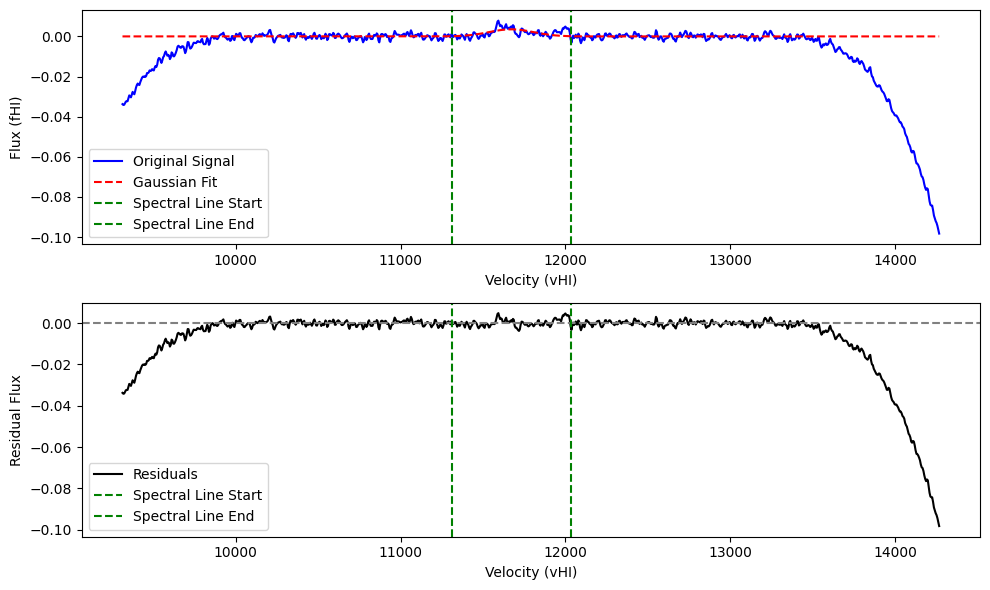

Data from signal mangaHI-8135-6103.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8135-6103.csv:
  Spectral Line Region -> Mean: -0.000057, Std Dev: 0.001225
  Non-Spectral Line Region -> Mean: -0.030358, Std Dev: 0.048068
  Percentage Difference in Mean: 99.81%
  Percentage Difference in Std Dev: -97.45%
--------------------------------------------------


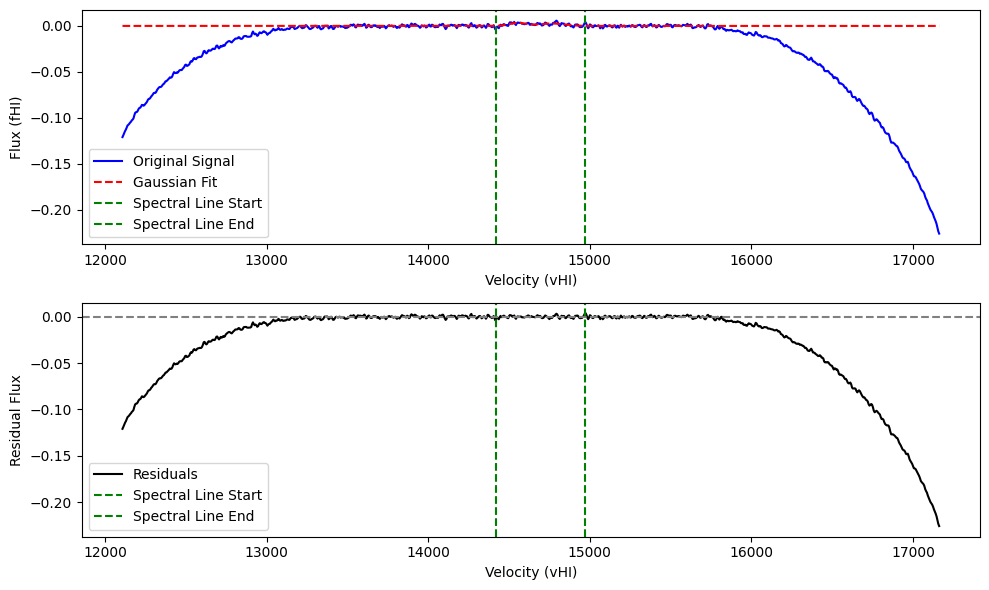

Results for signal mangaHI-7443-12701.csv:
  Spectral Line Region -> Mean: -0.000188, Std Dev: 0.000764
  Non-Spectral Line Region -> Mean: -0.000302, Std Dev: 0.001753
  Percentage Difference in Mean: 37.71%
  Percentage Difference in Std Dev: -56.44%
--------------------------------------------------


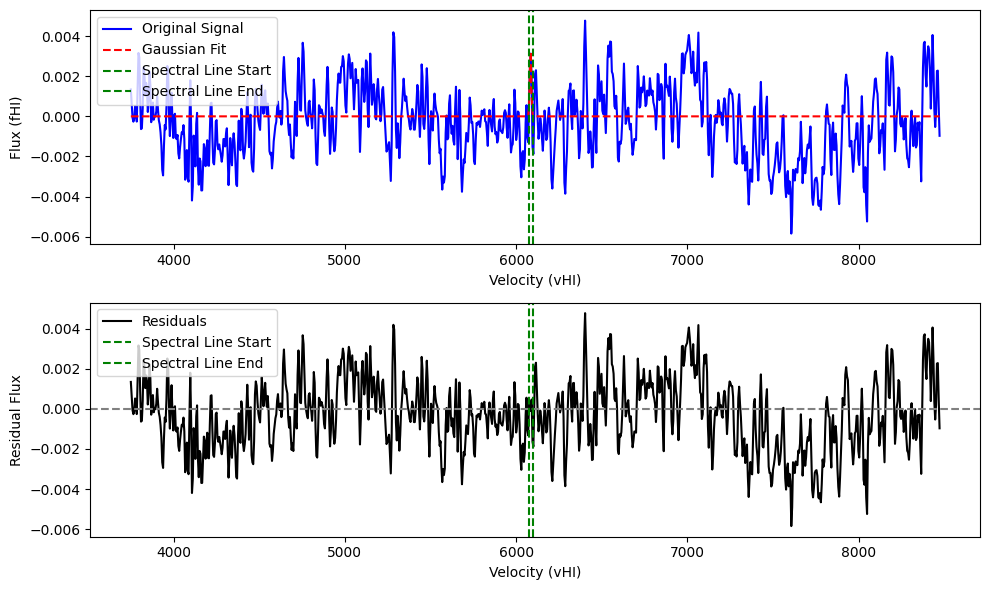

In [20]:
# Database connection details
db_config = {
    "host": "195.201.104.116",
    "user": "eta14802_astrobeam",
    "password": "PGdAR{F[1C#~",
    "database": "eta14802_astrobeam"
}

# Connect to the database
try:
    conn = mysql.connector.connect(**db_config)
    cursor = conn.cursor()

    # Find a src_file that has multiple points
    query = "SELECT src_file, COUNT(*) FROM gbt_data GROUP BY src_file ORDER BY COUNT(*) DESC LIMIT 1;"
    cursor.execute(query)
    src_file = cursor.fetchone()[0]
    print(f"Selected src_file: {src_file}")

    # Fetch all src_file names for sampling 20 random signals
    query = "SELECT DISTINCT src_file FROM gbt_data;"
    cursor.execute(query)
    src_files = [row[0] for row in cursor.fetchall()]
    
    # Randomly select 20 signals
    random_signals = random.sample(src_files, 20)
    print(f"Selected {len(random_signals)} random signals.")

    for src_file in random_signals:
        # Fetch all vHI and fHI values for the signal
        query = f"SELECT vHI, fHI FROM gbt_data WHERE src_file = '{src_file}' ORDER BY vHI;"
        cursor.execute(query)
        data = pd.DataFrame(cursor.fetchall(), columns=["vHI", "fHI"])

        # Remove NaNs
        data = data.dropna()

        # Extract velocity and flux
        x = data["vHI"].values
        y = data["fHI"].values

        # Perform normality test to check if a single Gaussian is sufficient
        stat, p_value = normaltest(y)

        # Fit a single Gaussian first
        fitter = fitting.LevMarLSQFitter()
        g_init = models.Gaussian1D(amplitude=np.max(y), mean=np.median(x), stddev=10)
        g_fit = fitter(g_init, x, y)

        # If the normality test fails (low p-value), attempt a double Gaussian fit
        if p_value < 0.05:
            print(f"Data from signal {src_file} can't be described by a single Gaussian fit.")
            g_init = models.Gaussian1D(amplitude=np.max(y), mean=np.median(x), stddev=10) + \
                     models.Gaussian1D(amplitude=np.max(y)/2, mean=np.median(x) + 10, stddev=10)
            g_fit = fitter(g_init, x, y)

        # Subtract the Gaussian fit from the original signal
        residuals = y - g_fit(x)

        # Identify spectral line region based on nonzero values of the Gaussian fit
        line_indices = np.where(g_fit(x) > 0.0001)[0]  # Indices where the fit is (practically) nonzero
        non_line_indices = np.setdiff1d(np.arange(len(x)), line_indices)  # Everything else

        # Compute noise statistics
        mean_line = np.mean(residuals[line_indices]) if len(line_indices) > 0 else np.nan
        std_line = np.std(residuals[line_indices]) if len(line_indices) > 0 else np.nan

        mean_non_line = np.mean(residuals[non_line_indices]) if len(non_line_indices) > 0 else np.nan
        std_non_line = np.std(residuals[non_line_indices]) if len(non_line_indices) > 0 else np.nan

        # Compute percentage differences
        if std_non_line > 0:
            std_diff_percentage = ((std_line - std_non_line) / std_non_line) * 100
        else:
            std_diff_percentage = np.nan

        if mean_non_line != 0:
            mean_diff_percentage = ((mean_line - mean_non_line) / abs(mean_non_line)) * 100
        else:
            mean_diff_percentage = np.nan

        # Print results
        print(f"Results for signal {src_file}:")
        print(f"  Spectral Line Region -> Mean: {mean_line:.6f}, Std Dev: {std_line:.6f}")
        print(f"  Non-Spectral Line Region -> Mean: {mean_non_line:.6f}, Std Dev: {std_non_line:.6f}")
        print(f"  Percentage Difference in Mean: {mean_diff_percentage:.2f}%")
        print(f"  Percentage Difference in Std Dev: {std_diff_percentage:.2f}%")
        print("-" * 50)

        # Plot results
        plt.figure(figsize=(10, 6))

        # Plot original signal and Gaussian fit
        plt.subplot(2, 1, 1)
        plt.plot(x, y, 'b-', label='Original Signal')
        plt.plot(x, g_fit(x), 'r--', label='Gaussian Fit')

        if len(line_indices) > 0:
            plt.axvline(x[line_indices[0]], color='g', linestyle='--', label="Spectral Line Start")
            plt.axvline(x[line_indices[-1]], color='g', linestyle='--', label="Spectral Line End")

        plt.xlabel("Velocity (vHI)")
        plt.ylabel("Flux (fHI)")
        plt.legend()

        # Plot residuals
        plt.subplot(2, 1, 2)
        plt.plot(x, residuals, '-k', label='Residuals')
        plt.axhline(0, color='gray', linestyle='--')

        # Mark spectral line region in residuals
        if len(line_indices) > 0:
            plt.axvline(x[line_indices[0]], color='g', linestyle='--', label="Spectral Line Start")
            plt.axvline(x[line_indices[-1]], color='g', linestyle='--', label="Spectral Line End")

        plt.xlabel("Velocity (vHI)")
        plt.ylabel("Residual Flux")
        plt.legend()

        plt.tight_layout()
        plt.show()

except mysql.connector.Error as err:
    print("Error:", err)

finally:
    cursor.close()
    conn.close()


Selected src_file: mangaHI-8716-9101.csv
Fetched 1024 data points.


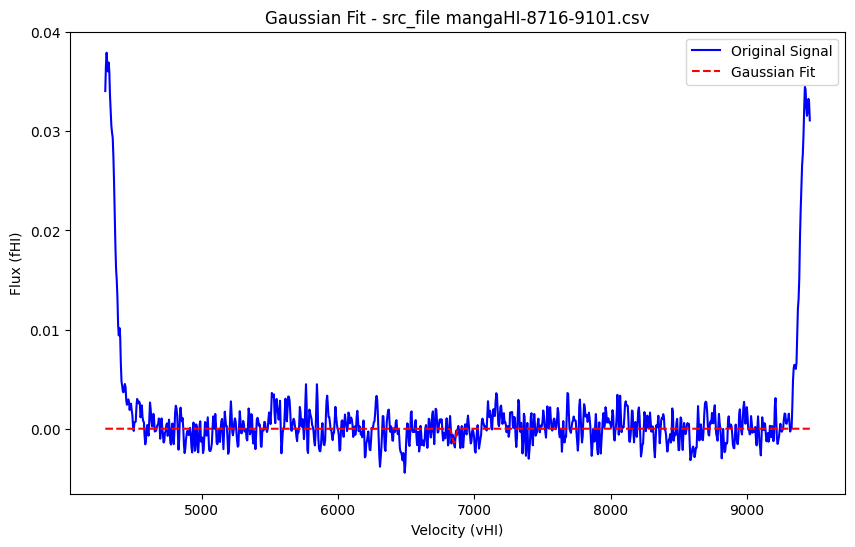